In [1]:
import pyodbc as p
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
from scipy.stats import pearsonr


## 1. Load Data into DataFrames

In [2]:
# Connection details
server = 'ARAM\\SQLEXPRESS'  # Your server name
database = 'Chinook'         # Your database name

# SQLAlchemy connection string
connection_string = f'mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server'

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# List of tables to load
tables = ["Album", "Artist", "Customer", "Employee", "Genre", "Invoice", "InvoiceLine", "MediaType", "Playlist", "PlaylistTrack", "Track"]

# Load each table into a DataFrame
dataframes = {table: pd.read_sql(f"SELECT * FROM {table}", engine) for table in tables}

# Display the DataFrame
print(dataframes)



{'Album':      AlbumId                                              Title  ArtistId
0          1              For Those About To Rock We Salute You         1
1          2                                  Balls to the Wall         2
2          3                                  Restless and Wild         2
3          4                                  Let There Be Rock         1
4          5                                           Big Ones         3
..       ...                                                ...       ...
342      343                             Respighi:Pines of Rome       226
343      344  Schubert: The Late String Quartets & String Qu...       272
344      345                                Monteverdi: L'Orfeo       273
345      346                              Mozart: Chamber Music       274
346      347  Koyaanisqatsi (Soundtrack from the Motion Pict...       275

[347 rows x 3 columns], 'Artist':      ArtistId                                               Name
0 

## 2. Initial Data Exploration

In [3]:
for table, df in dataframes.items():
    print(f"\nTable: {table}")
    print(df.info())
    print(df.describe())


Table: Album
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AlbumId   347 non-null    int64 
 1   Title     347 non-null    object
 2   ArtistId  347 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB
None
          AlbumId    ArtistId
count  347.000000  347.000000
mean   174.000000  121.942363
std    100.314505   77.793131
min      1.000000    1.000000
25%     87.500000   58.000000
50%    174.000000  112.000000
75%    260.500000  179.500000
max    347.000000  275.000000

Table: Artist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ArtistId  275 non-null    int64 
 1   Name      275 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB
None
         ArtistId
count  275.000000
mean 

## 3. Identify Key Variables and Plot Distributions

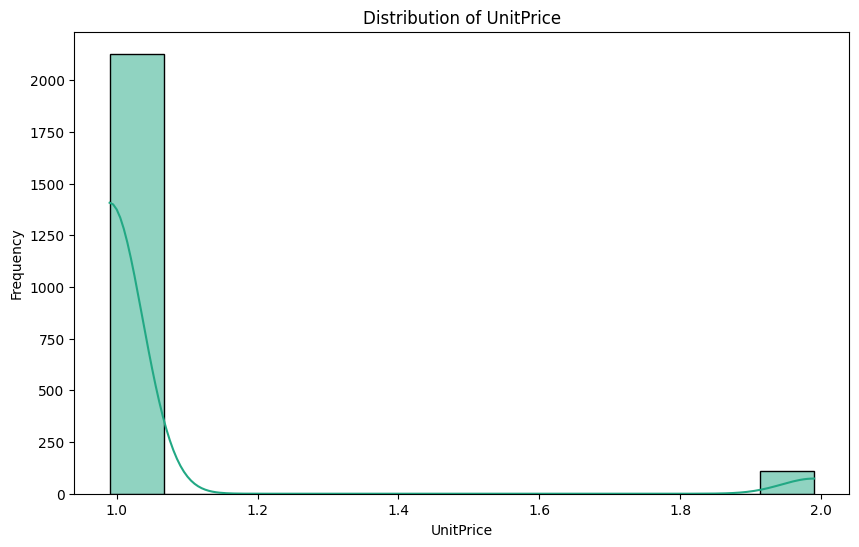

Shapiro-Wilk test for UnitPrice: Statistics=0.22256856261663105, p-value=2.1025064392269568e-70
The UnitPrice distribution is significantly different from normal (p-value < 0.05).


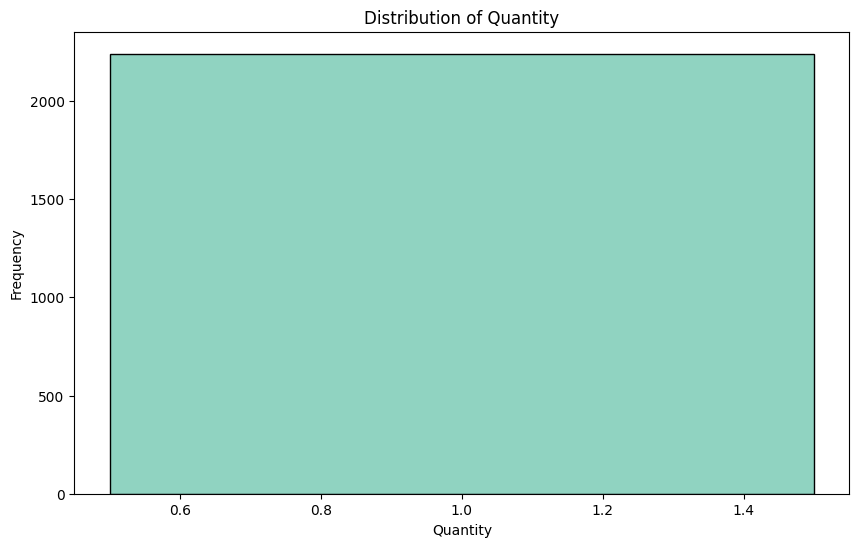

Shapiro-Wilk test for Quantity could not be performed due to insufficient unique values.


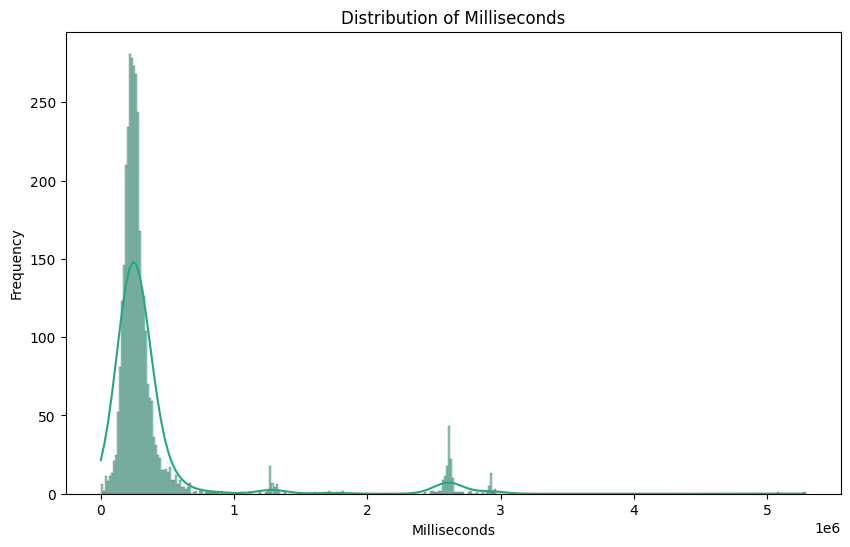

Shapiro-Wilk test for Milliseconds: Statistics=0.4069350980582944, p-value=2.7287436202313686e-75
The Milliseconds distribution is significantly different from normal (p-value < 0.05).


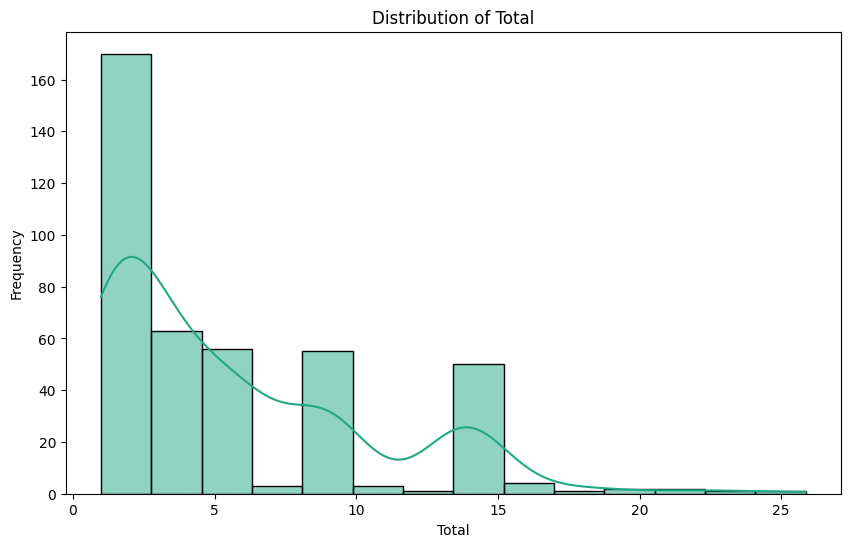

Shapiro-Wilk test for Total: Statistics=0.8367111017894937, p-value=3.4001843897448504e-20
The Total distribution is significantly different from normal (p-value < 0.05).


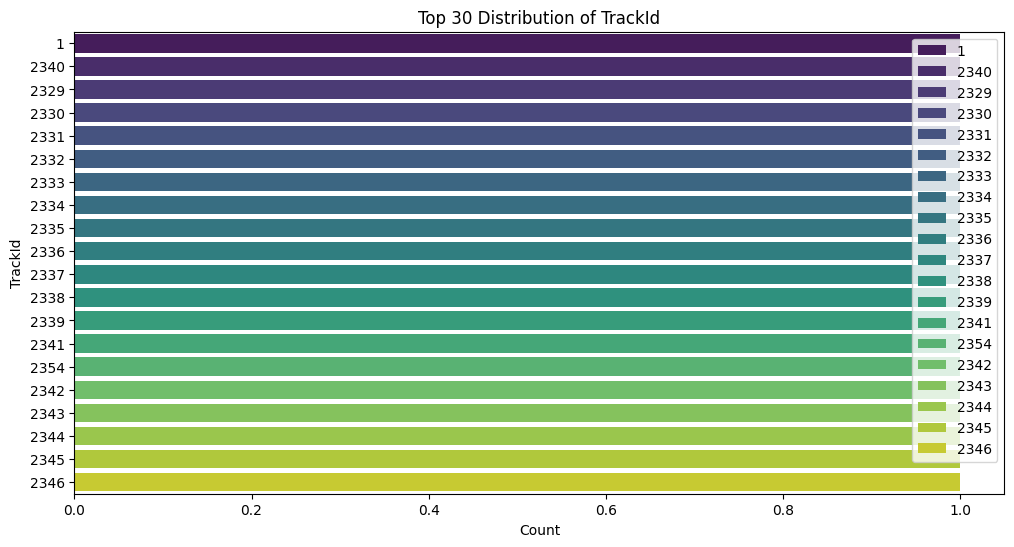

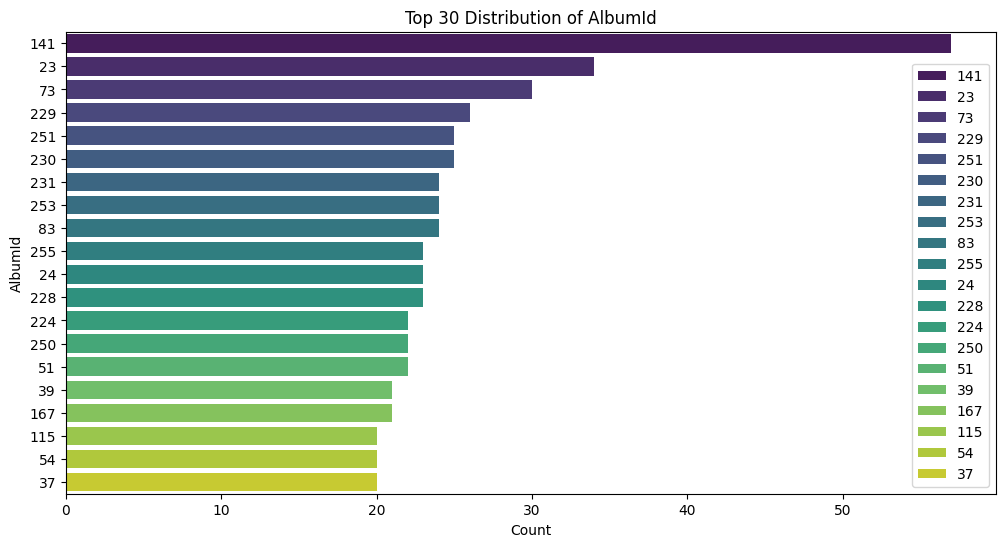

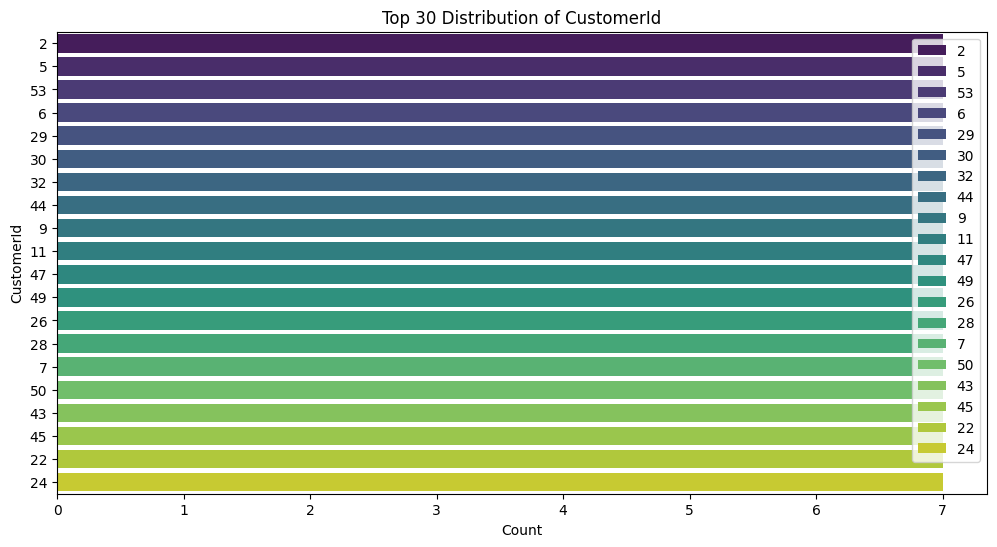

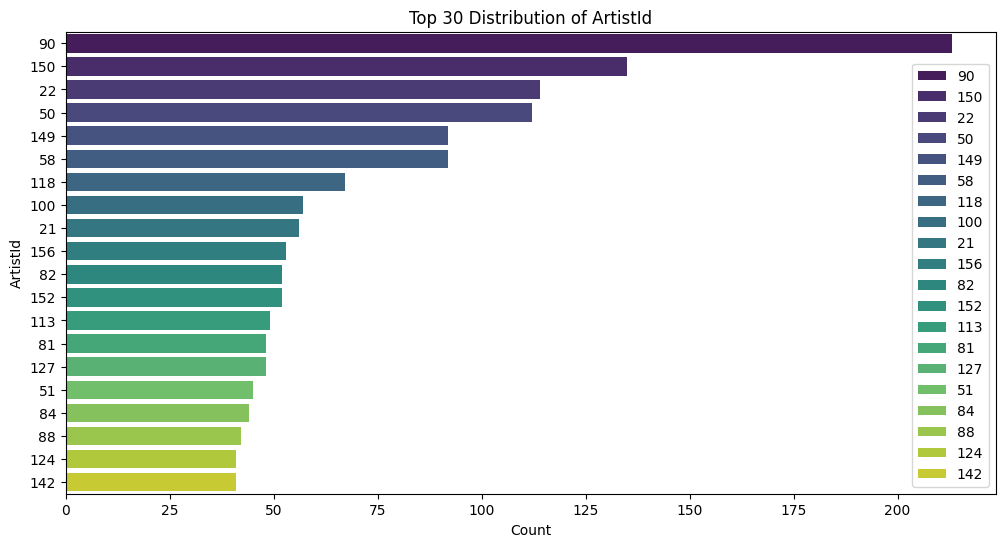

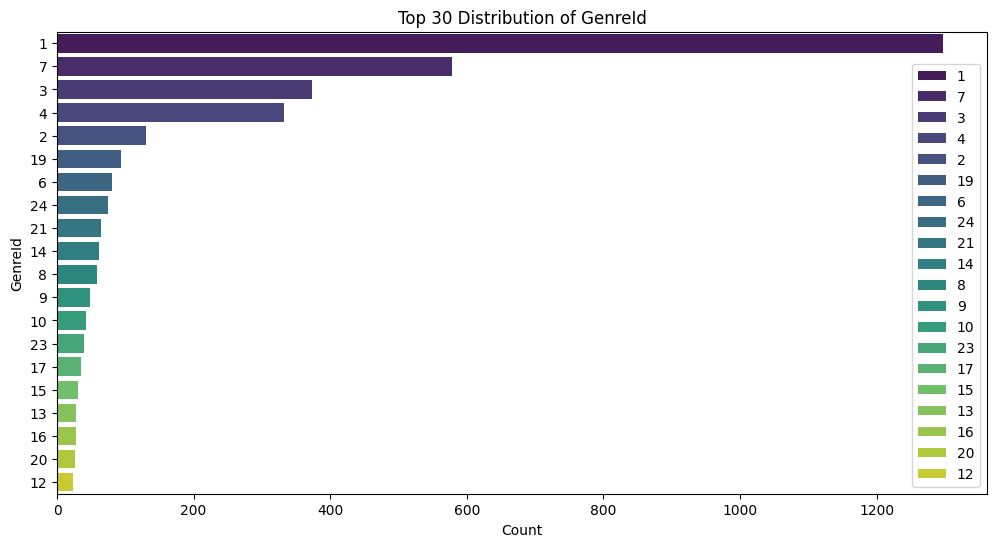

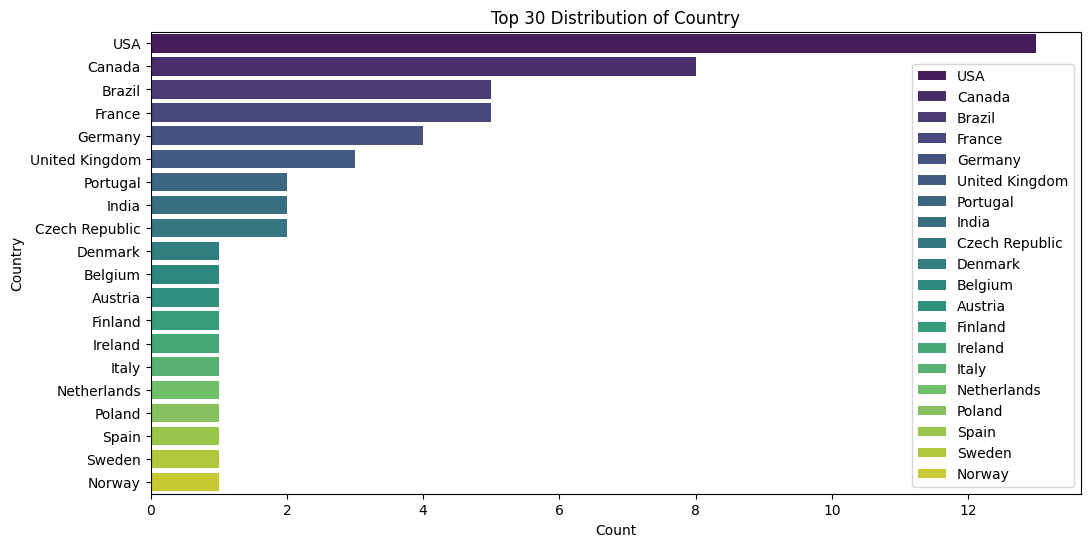

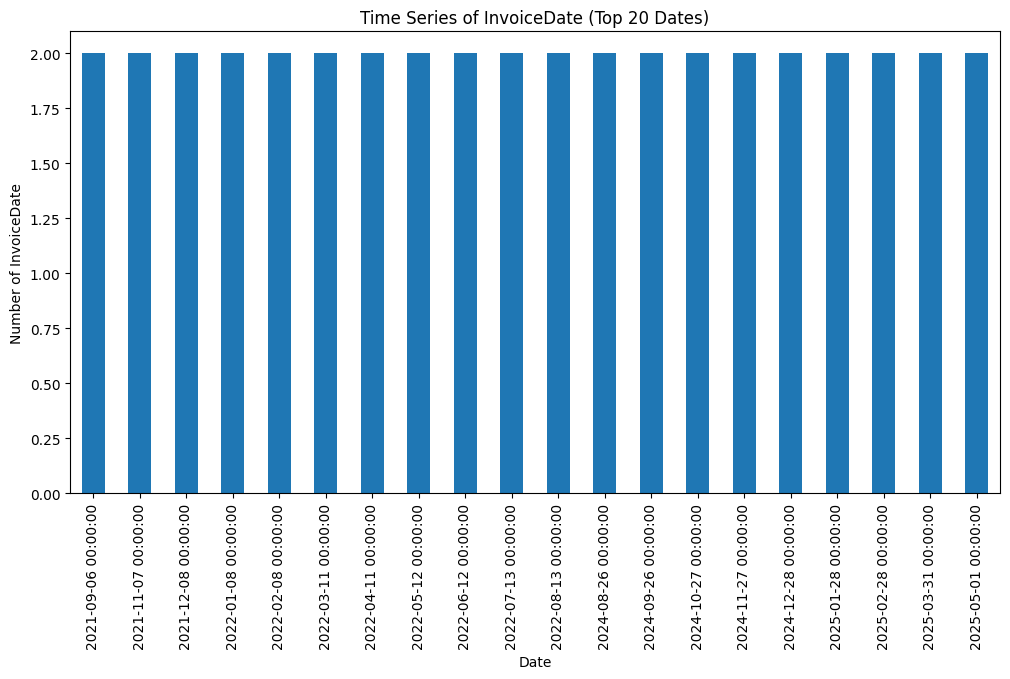

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Assuming dataframes is a dictionary containing your data
# dataframes = {"InvoiceLine": <DataFrame>, "Track": <DataFrame>, ...}

# Define additional key variables
numeric_key_variables = {
    "UnitPrice": dataframes["InvoiceLine"]["UnitPrice"],
    "Quantity": dataframes["InvoiceLine"]["Quantity"],
    "Milliseconds": dataframes["Track"]["Milliseconds"],
    "Total": dataframes["Invoice"]["Total"]
}

categorical_key_variables = {
    "TrackId": dataframes["Track"]["TrackId"],
    "AlbumId": dataframes["Track"]["AlbumId"],
    "CustomerId": dataframes["Invoice"]["CustomerId"],
    "ArtistId": dataframes["Track"].merge(dataframes["Album"], on="AlbumId")["ArtistId"],
    "GenreId": dataframes["Track"]["GenreId"],
    "Country": dataframes["Customer"]["Country"]
}

date_key_variables = {
    "InvoiceDate": dataframes["Invoice"]["InvoiceDate"]
}

# Example color scheme using seaborn's color palette
palette = "viridis"
color = sns.color_palette(palette, as_cmap=True)

# Function to perform Shapiro-Wilk test and plot distributions for numeric variables
def analyze_numeric_distribution(var_name, series):
    plt.figure(figsize=(10, 6))
    sns.histplot(series.dropna(), kde=True, color=color(0.6))
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var_name)
    plt.ylabel("Frequency")
    plt.show()
    
    # Perform Shapiro-Wilk test
    if series.dropna().nunique() > 1:  # Ensure there are enough unique values for the test
        shapiro_stat, p_value = stats.shapiro(series.dropna())
        print(f"Shapiro-Wilk test for {var_name}: Statistics={shapiro_stat}, p-value={p_value}")
        
        # Check p-value
        if p_value < 0.05:
            print(f"The {var_name} distribution is significantly different from normal (p-value < 0.05).")
        else:
            print(f"The {var_name} distribution is not significantly different from normal (p-value >= 0.05).")
    else:
        print(f"Shapiro-Wilk test for {var_name} could not be performed due to insufficient unique values.")

# Function to plot distributions for categorical variables, limited to top 15 categories
def analyze_categorical_distribution(var_name, series):
    top_20 = series.value_counts().nlargest(20)
    plt.figure(figsize=(12, 6))
    sns.countplot(y=pd.Categorical(series, categories=top_20.index),hue=pd.Categorical(series, categories=top_20.index), order=top_20.index, palette=palette)
    plt.title(f"Top 30 Distribution of {var_name}")
    plt.xlabel("Count")
    plt.ylabel(var_name)
    plt.show()

# Function to plot time series trends for date variables, showing only the first 20 dates
def analyze_date_distribution(var_name, series):
    plt.figure(figsize=(12, 6))
    series = pd.to_datetime(series)
    series_counts = series.value_counts().nlargest(20).sort_index()
    series_counts.plot(kind='bar')
    plt.title(f"Time Series of {var_name} (Top 20 Dates)")
    plt.xlabel("Date")
    plt.ylabel(f"Number of {var_name}")
    plt.show()

# Analyze numeric key variables
for var_name, series in numeric_key_variables.items():
    analyze_numeric_distribution(var_name, series)

# Analyze categorical key variables
for var_name, series in categorical_key_variables.items():
    analyze_categorical_distribution(var_name, series)

# Analyze date key variables
for var_name, series in date_key_variables.items():
    analyze_date_distribution(var_name, series)


## 4. Choose Palettes for Better Understanding

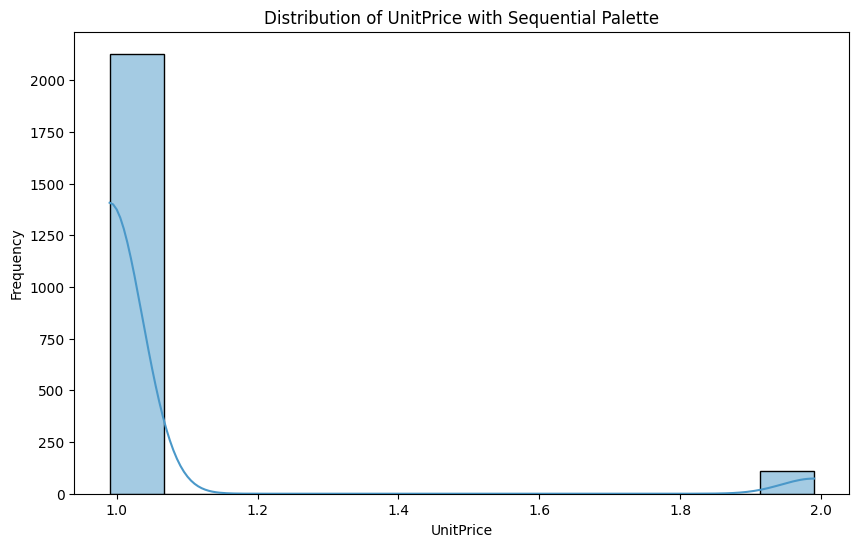

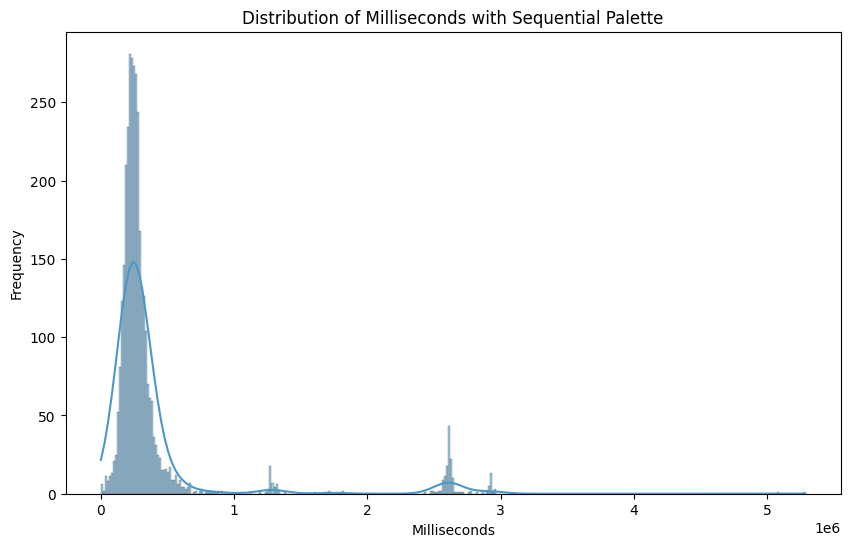

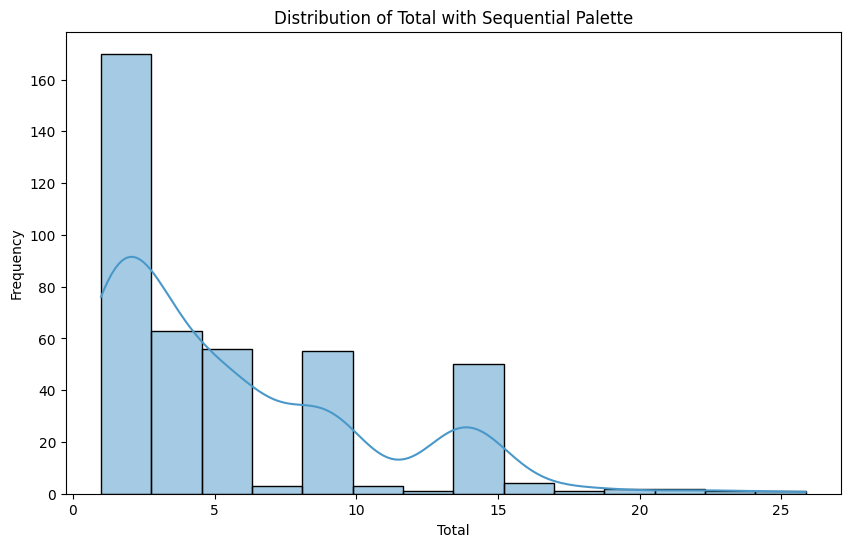

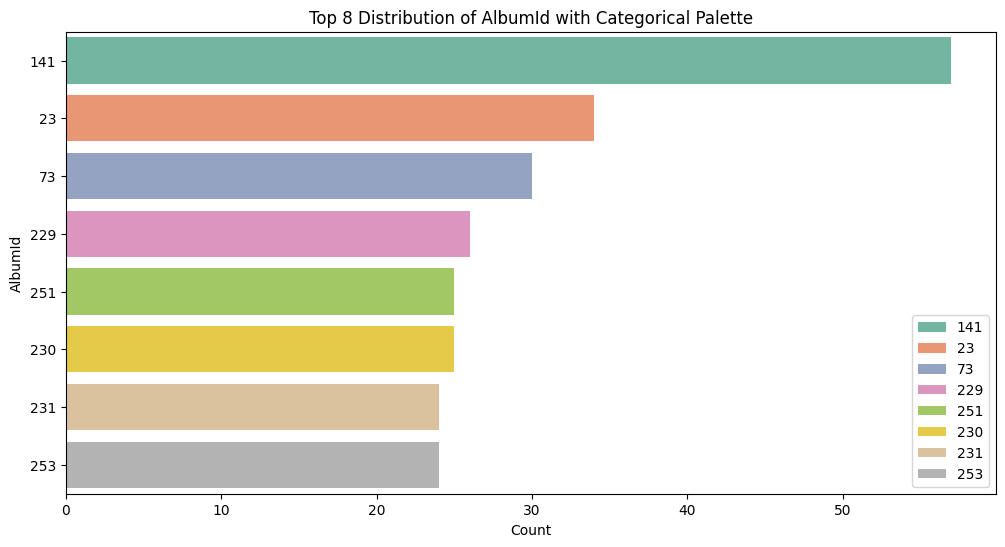

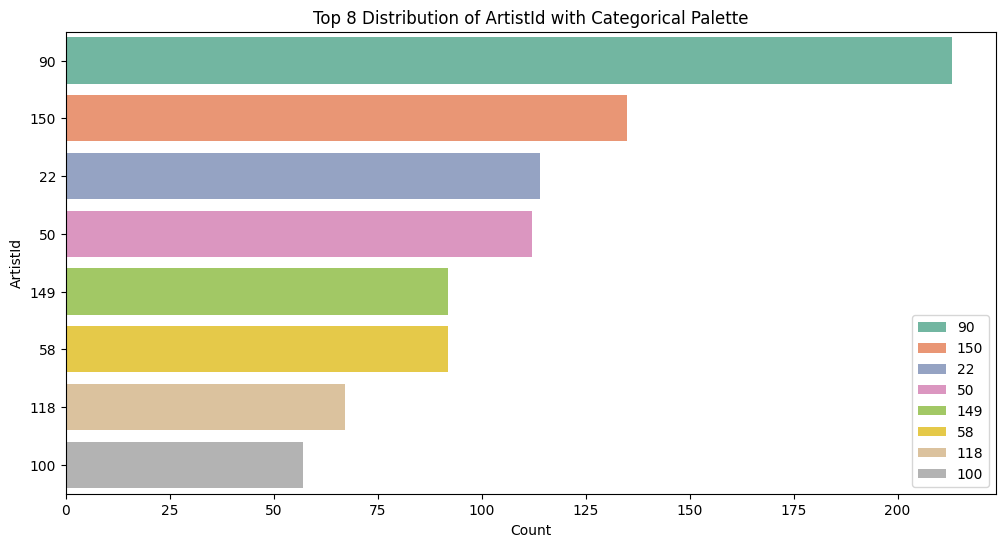

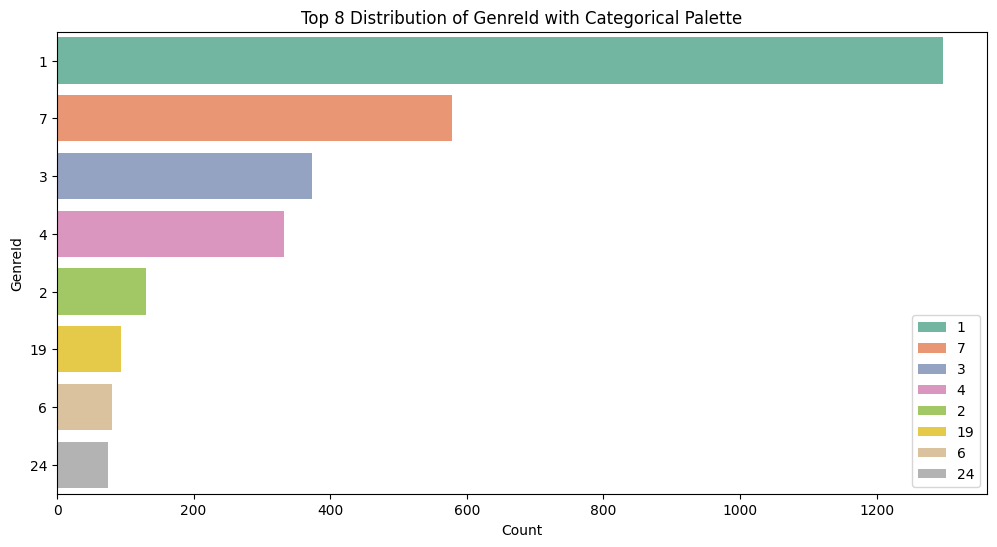

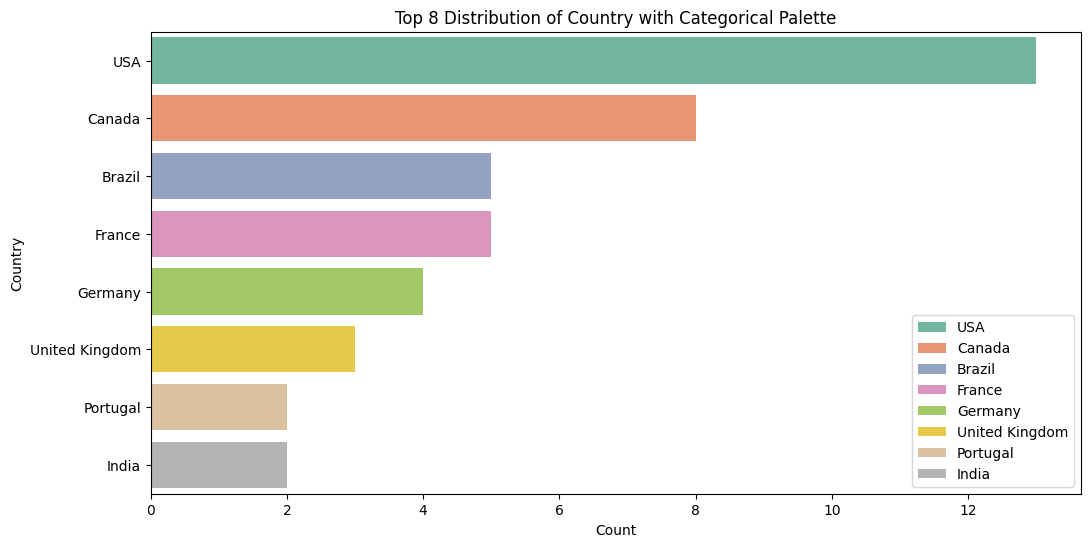

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example key variables
numeric_key_variables = {
    "UnitPrice": dataframes["InvoiceLine"]["UnitPrice"],
    
    "Milliseconds": dataframes["Track"]["Milliseconds"],
    "Total": dataframes["Invoice"]["Total"]
}

categorical_key_variables = {
    "AlbumId": dataframes["Track"]["AlbumId"],
    "ArtistId": dataframes["Track"].merge(dataframes["Album"], on="AlbumId")["ArtistId"],
    "GenreId": dataframes["Track"]["GenreId"],
    "Country": dataframes["Customer"]["Country"]
}

# Example color palettes
sequential_palette = sns.color_palette("Blues", as_cmap=True)
diverging_palette = sns.diverging_palette(220, 20, as_cmap=True)
categorical_palette = sns.color_palette("Set2")

# Function to plot numeric variable distributions using a sequential palette
def plot_numeric_distribution(var_name, series):
    plt.figure(figsize=(10, 6))
    sns.histplot(series.dropna(), kde=True, color=sequential_palette(0.6))
    plt.title(f"Distribution of {var_name} with Sequential Palette")
    plt.xlabel(var_name)
    plt.ylabel("Frequency")
    plt.show()

# Function to plot categorical variable distributions using a categorical palette
def plot_categorical_distribution(var_name, series):
    top_8 = series.value_counts().nlargest(8)
    plt.figure(figsize=(12, 6))
    sns.countplot(y=pd.Categorical(series, categories=top_8.index),hue=pd.Categorical(series, categories=top_8.index), order=top_8.index, palette=categorical_palette)
    plt.title(f"Top 8 Distribution of {var_name} with Categorical Palette")
    plt.xlabel("Count")
    plt.ylabel(var_name)
    plt.show()

# Function to plot date variable trends using a diverging palette
def plot_date_distribution(var_name, series):
    plt.figure(figsize=(12, 6))
    series = pd.to_datetime(series)
    series_counts = series.value_counts().nlargest(20).sort_index()
    sns.barplot(x=series_counts.index, y=series_counts.values, palette=diverging_palette)
    plt.title(f"Time Series of {var_name} (Top 20 Dates) with Diverging Palette")
    plt.xlabel("Date")
    plt.ylabel(f"Number of {var_name}")
    plt.xticks(rotation=45)
    plt.show()

# Plot distributions for numeric key variables
for var_name, series in numeric_key_variables.items():
    plot_numeric_distribution(var_name, series)

# Plot distributions for categorical key variables
for var_name, series in categorical_key_variables.items():
    plot_categorical_distribution(var_name, series)




## 5. Check Normality of Key Numeric Variables



**UnitPrice**
Shapiro-Wilk test: Statistics=0.223, p-value=0.000
D'Agostino's K-squared test: Statistics=1865.034, p-value=0.000
Anderson-Darling test: Statistics=809.637
  At 15.0%: 0.575, Rejected
  At 10.0%: 0.655, Rejected
  At 5.0%: 0.786, Rejected
  At 2.5%: 0.916, Rejected
  At 1.0%: 1.090, Rejected
UnitPrice distribution is not normal. Applying Box-Cox transformation.

Post-transformation (Box-Cox) **UnitPrice**
Shapiro-Wilk test: Statistics=0.223, p-value=0.000
D'Agostino's K-squared test: Statistics=1865.034, p-value=0.000
Anderson-Darling test: Statistics=809.637
  At 15.0%: 0.575, Rejected
  At 10.0%: 0.655, Rejected
  At 5.0%: 0.786, Rejected
  At 2.5%: 0.916, Rejected
  At 1.0%: 1.090, Rejected


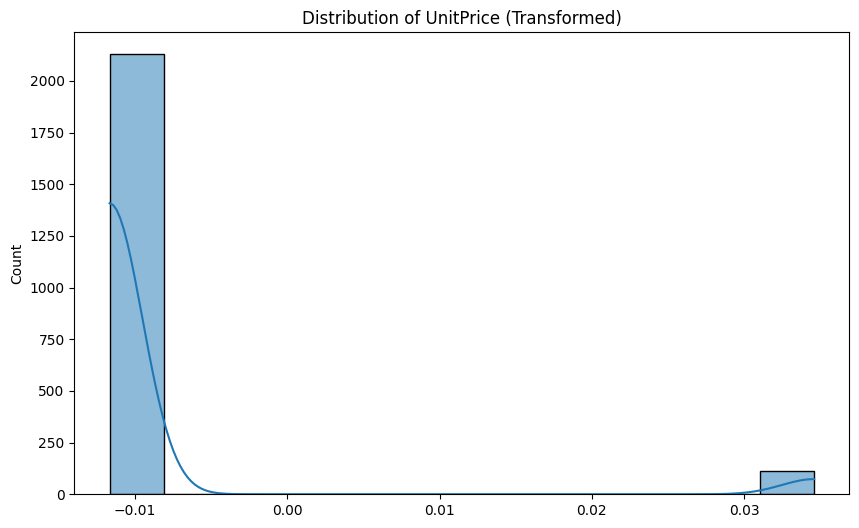

No positive or unique values for Quantity. Cannot apply Box-Cox transformation.

**Milliseconds**
Shapiro-Wilk test: Statistics=0.407, p-value=0.000
D'Agostino's K-squared test: Statistics=2821.044, p-value=0.000
Anderson-Darling test: Statistics=791.066
  At 15.0%: 0.575, Rejected
  At 10.0%: 0.655, Rejected
  At 5.0%: 0.786, Rejected
  At 2.5%: 0.917, Rejected
  At 1.0%: 1.091, Rejected
Milliseconds distribution is not normal. Applying Box-Cox transformation.

Post-transformation (Box-Cox) **Milliseconds**
Shapiro-Wilk test: Statistics=0.794, p-value=0.000
D'Agostino's K-squared test: Statistics=934.013, p-value=0.000
Anderson-Darling test: Statistics=189.256
  At 15.0%: 0.575, Rejected
  At 10.0%: 0.655, Rejected
  At 5.0%: 0.786, Rejected
  At 2.5%: 0.917, Rejected
  At 1.0%: 1.091, Rejected


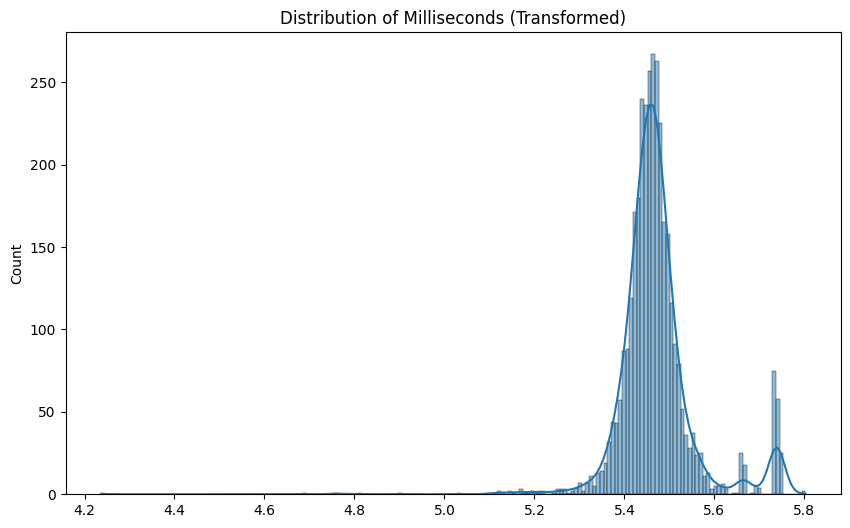


**Total**
Shapiro-Wilk test: Statistics=0.837, p-value=0.000
D'Agostino's K-squared test: Statistics=77.621, p-value=0.000
Anderson-Darling test: Statistics=23.419
  At 15.0%: 0.571, Rejected
  At 10.0%: 0.650, Rejected
  At 5.0%: 0.780, Rejected
  At 2.5%: 0.909, Rejected
  At 1.0%: 1.082, Rejected
Total distribution is not normal. Applying Box-Cox transformation.

Post-transformation (Box-Cox) **Total**
Shapiro-Wilk test: Statistics=0.924, p-value=0.000
D'Agostino's K-squared test: Statistics=170.969, p-value=0.000
Anderson-Darling test: Statistics=11.359
  At 15.0%: 0.571, Rejected
  At 10.0%: 0.650, Rejected
  At 5.0%: 0.780, Rejected
  At 2.5%: 0.909, Rejected
  At 1.0%: 1.082, Rejected


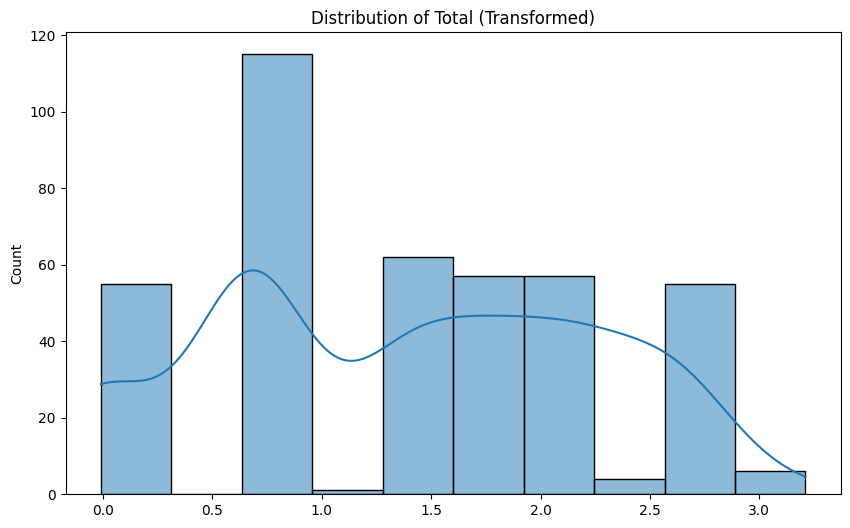

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assume dataframes is your loaded dictionary of dataframes
# Define key numeric variables
numeric_key_variables = {
    "UnitPrice": dataframes["InvoiceLine"]["UnitPrice"],
    "Quantity": dataframes["InvoiceLine"]["Quantity"],
    "Milliseconds": dataframes["Track"]["Milliseconds"],
    "Total": dataframes["Invoice"]["Total"]
}

# Function to check normality and apply transformations
def check_normality_and_transform(var_name, series):
    # Remove zero or negative values for Box-Cox transformation
    series = series[series > 0]
    
    if series.empty or series.nunique() <= 1:
        print(f"No positive or unique values for {var_name}. Cannot apply Box-Cox transformation.")
        return
    
    # Initial normality tests
    try:
        shapiro_stat, shapiro_p = stats.shapiro(series)
    except ValueError:
        shapiro_stat, shapiro_p = np.nan, np.nan
    dagostino_stat, dagostino_p = stats.normaltest(series)
    anderson_result = stats.anderson(series, dist='norm')

    # Print initial normality test results
    print(f"\n**{var_name}**")
    print(f"Shapiro-Wilk test: Statistics={shapiro_stat:.3f}, p-value={shapiro_p:.3f}")
    print(f"D'Agostino's K-squared test: Statistics={dagostino_stat:.3f}, p-value={dagostino_p:.3f}")
    print(f"Anderson-Darling test: Statistics={anderson_result.statistic:.3f}")
    for i, (crit, sig) in enumerate(zip(anderson_result.critical_values, anderson_result.significance_level)):
        print(f"  At {sig}%: {crit:.3f}, {'Rejected' if anderson_result.statistic > crit else 'Not Rejected'}")
    
    # Determine if any test indicates non-normality
    if shapiro_p < 0.05 or dagostino_p < 0.05 or any(anderson_result.statistic > crit for crit in anderson_result.critical_values):
        print(f"{var_name} distribution is not normal. Applying Box-Cox transformation.")
        # Apply Box-Cox transformation
        try:
            transformed_series, _ = stats.boxcox(series + 1e-6)  # Add a small value to avoid zero values
            series = pd.Series(transformed_series)
        except ValueError:
            print(f"Box-Cox transformation failed for {var_name}.")
            return
        
        # Re-check normality after transformation
        try:
            shapiro_stat, shapiro_p = stats.shapiro(series)
        except ValueError:
            shapiro_stat, shapiro_p = np.nan, np.nan
        dagostino_stat, dagostino_p = stats.normaltest(series)
        anderson_result = stats.anderson(series, dist='norm')
        
        # Print post-transformation normality test results
        print(f"\nPost-transformation (Box-Cox) **{var_name}**")
        print(f"Shapiro-Wilk test: Statistics={shapiro_stat:.3f}, p-value={shapiro_p:.3f}")
        print(f"D'Agostino's K-squared test: Statistics={dagostino_stat:.3f}, p-value={dagostino_p:.3f}")
        print(f"Anderson-Darling test: Statistics={anderson_result.statistic:.3f}")
        for i, (crit, sig) in enumerate(zip(anderson_result.critical_values, anderson_result.significance_level)):
            print(f"  At {sig}%: {crit:.3f}, {'Rejected' if anderson_result.statistic > crit else 'Not Rejected'}")
    
    else:
        print(f"{var_name} distribution is normal.")
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(series, kde=True)
    plt.title(f"Distribution of {var_name} (Transformed)" if shapiro_p < 0.05 or dagostino_p < 0.05 else f"Distribution of {var_name}")
    plt.show()

# Apply the function to each numeric key variable
for var_name, series in numeric_key_variables.items():
    check_normality_and_transform(var_name, series)


## 6. Identify and Handle Outliers

In [7]:
from scipy import stats

for var, series in numeric_key_variables.items():
    z_scores = stats.zscore(series)
    outliers = series[(z_scores > 3) | (z_scores < -3)]
    print(f"Outliers in {var}: {outliers}\n")

    # Decision to remove outliers (example decision)
    cleaned_series = series[(z_scores <= 3) & (z_scores >= -3)]
    print(f"Cleaned {var}: {cleaned_series.describe()}\n")


Outliers in UnitPrice: 467     1.99
468     1.99
469     1.99
470     1.99
471     1.99
        ... 
2196    1.99
2197    1.99
2198    1.99
2199    1.99
2239    1.99
Name: UnitPrice, Length: 111, dtype: float64

Cleaned UnitPrice: count    2129.00
mean        0.99
std         0.00
min         0.99
25%         0.99
50%         0.99
75%         0.99
max         0.99
Name: UnitPrice, dtype: float64

Outliers in Quantity: Series([], Name: Quantity, dtype: int64)

Cleaned Quantity: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Quantity, dtype: float64

Outliers in Milliseconds: 2818    2622250
2819    5286953
2820    2621708
2821    2618000
2822    2626626
         ...   
3359    2612779
3360    2612028
3361    2609526
3362    2497956
3363    2582957
Name: Milliseconds, Length: 160, dtype: int64

Cleaned Milliseconds: count    3.343000e+03
mean     2.836255e+05
std      1.748324e+05
min      1.071000e+03
25%      2.052880e+05
5

## 7. Hypothesis Testing

### Popular Genres and Average Prices

            Quantity
Name_Genre          
Rock             835
Latin            386
Metal            264


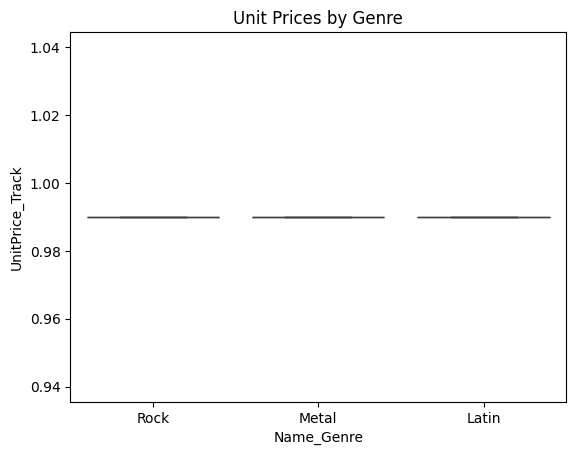

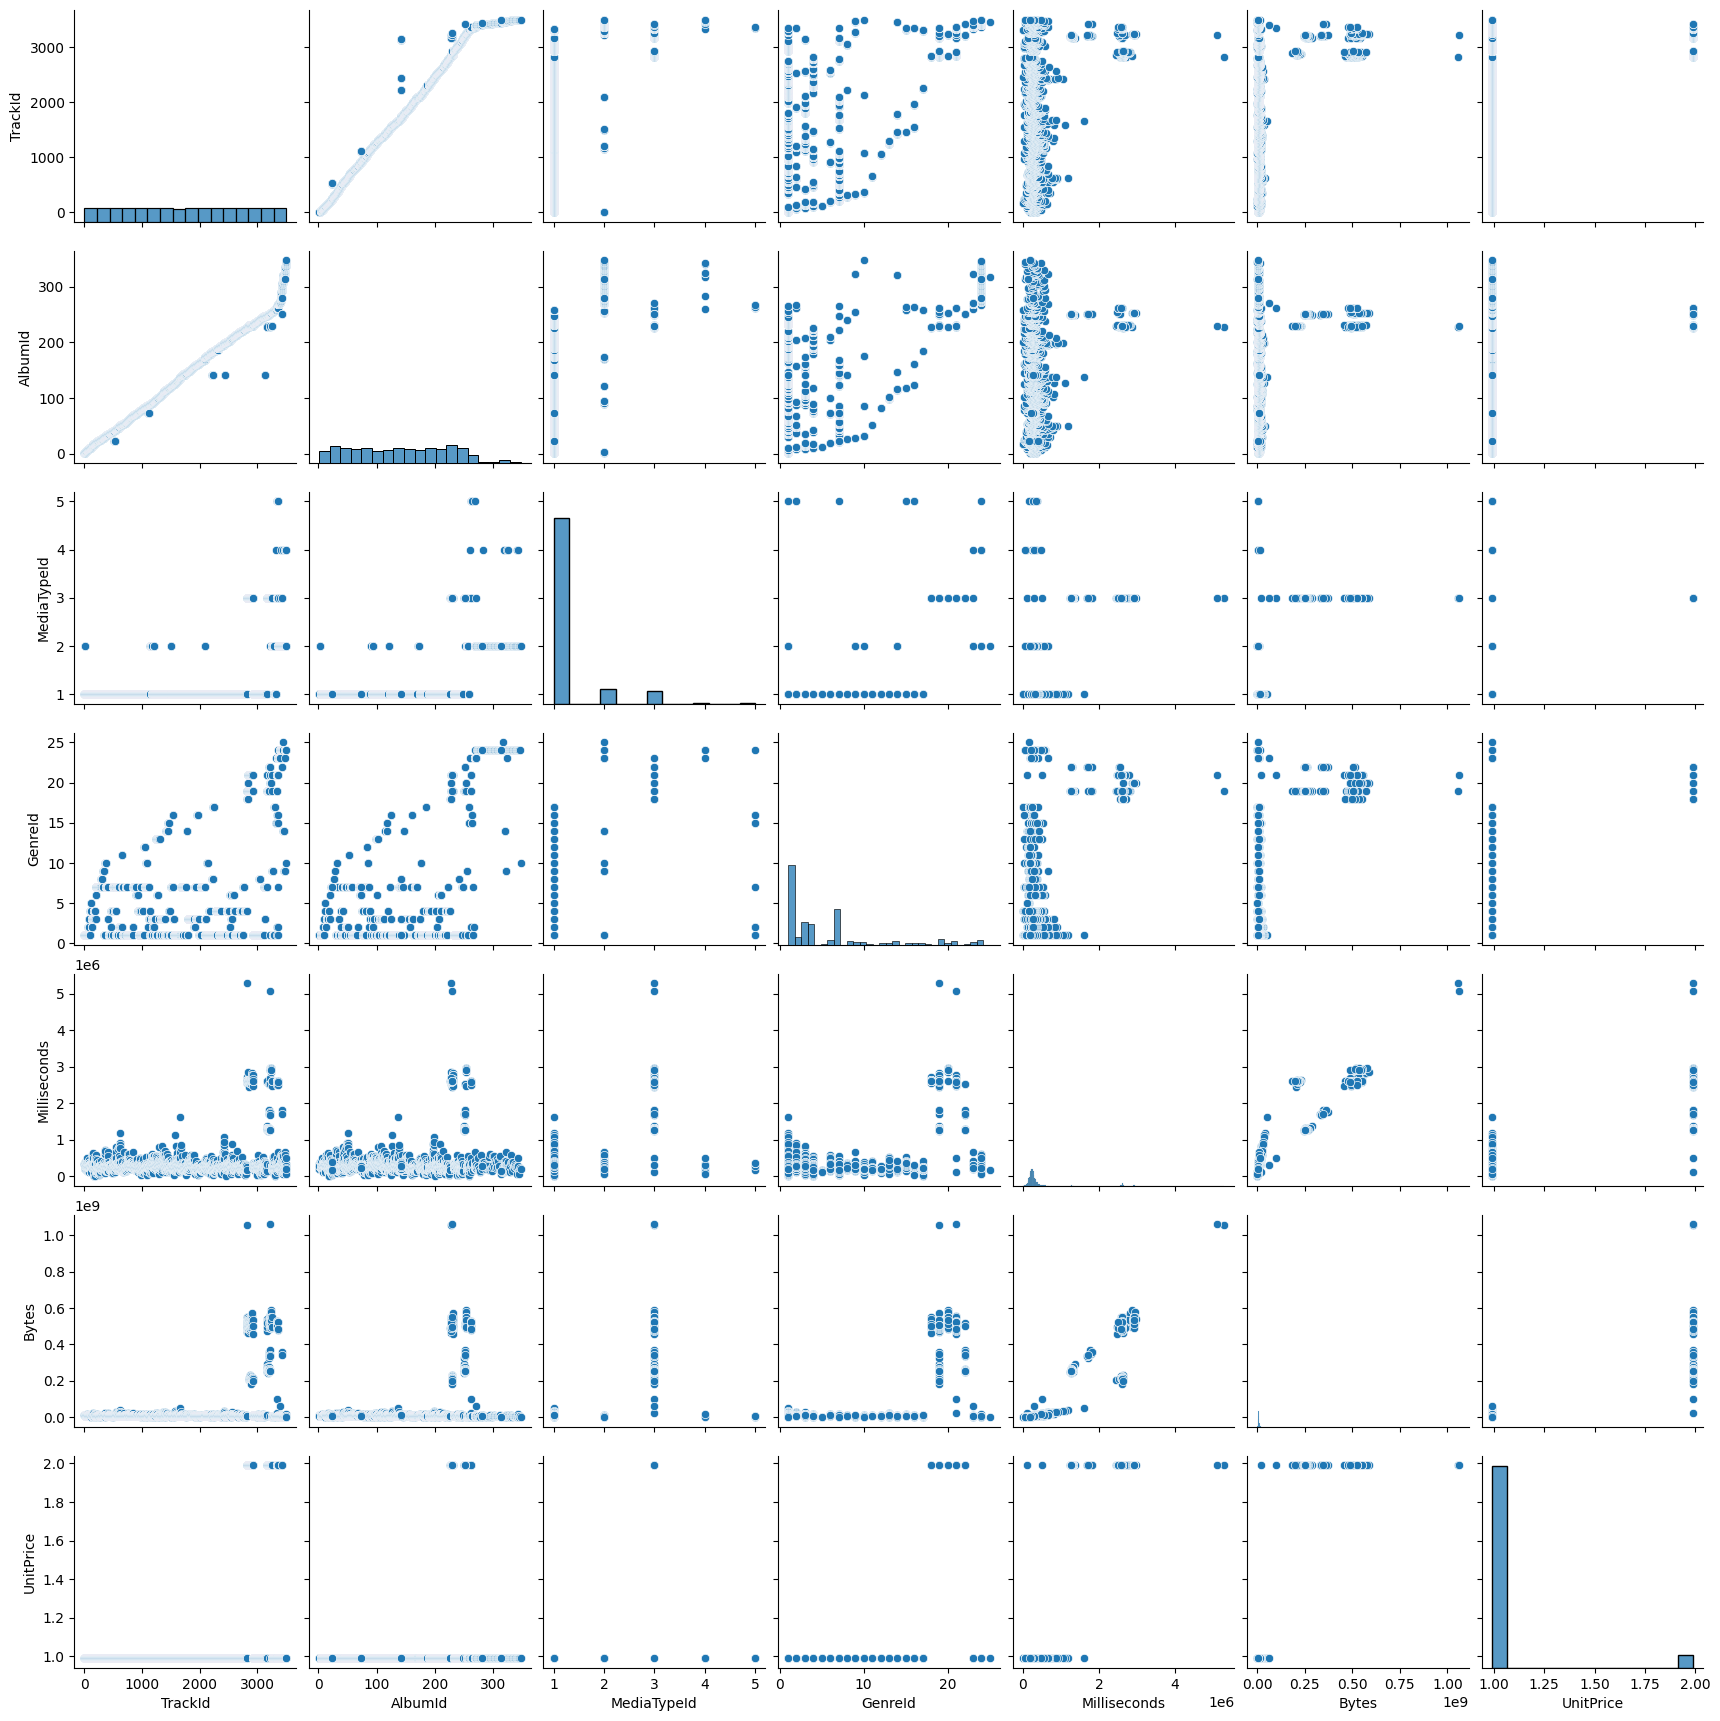

In [8]:
# Find the top 3 genres by number of tracks sold
top_genres = (dataframes["InvoiceLine"]
              .merge(dataframes["Track"], on="TrackId",suffixes=('_Track', '_Genre'))
              .merge(dataframes["Genre"], on="GenreId",suffixes=('_Track', '_Genre'))
              .groupby("Name_Genre")
              .agg({"Quantity": "sum"})
              .nlargest(3, "Quantity"))
print(top_genres)

# Compare average prices among these genres
prices_by_genre = (dataframes["InvoiceLine"]
                   .merge(dataframes["Track"], on="TrackId",suffixes=('_Track', '_Genre'))
                   .merge(dataframes["Genre"], on="GenreId",suffixes=('_Track', '_Genre'))
                   .query("Name_Genre in @top_genres.index"))

sns.boxplot(x="Name_Genre", y="UnitPrice_Track", data=prices_by_genre)
plt.title("Unit Prices by Genre")
df1=sns.load_dataset('iris')
sns.pairplot(df,kind='scatter')
plt.show()


### Here are some important facts about the Pearson correlation coefficient:

The Pearson correlation coefficient can take on any real value in the range −1 ≤ r ≤ 1.

The maximum value r = 1 corresponds to the case in which there’s a perfect positive linear relationship between x and y. In other words, larger x values correspond to larger y values and vice versa.

The value r > 0 indicates positive correlation between x and y.

The value r = 0 corresponds to the case in which there’s no linear relationship between x and y.

The value r < 0 indicates negative correlation between x and y.

The minimal value r = −1 corresponds to the case when there’s a perfect negative linear relationship between x and y. In other words, larger x values correspond to smaller y values and vice versa.

### Independence Between Track Length and Price

In [9]:

track_length_price = dataframes["Track"].merge(dataframes["InvoiceLine"], on="TrackId",suffixes=('_Track', '_InvoiceLine'))
corr, p_value = pearsonr(track_length_price["Milliseconds"], track_length_price["UnitPrice_InvoiceLine"])
print(f"Correlation between track length and price: {corr}, p-value: {p_value}")

Correlation between track length and price: 0.9335328265650042, p-value: 0.0


### Independence Between Genre and Media Type

In [10]:
from scipy.stats import chi2_contingency

genre_media = (dataframes["Track"]
               .merge(dataframes["Genre"], on="GenreId",suffixes=('_MediaType', '_Genre'))
               .merge(dataframes["MediaType"], on="MediaTypeId",suffixes=('_MediaType', '_Genre'))
               .groupby(["Name_Genre", "MediaTypeId"])
               .size()
               .unstack(fill_value=0))

chi2, p, dof, expected = chi2_contingency(genre_media)
print(f"Chi-square test for independence between genre and media type: chi2={chi2}, p-value={p}")


Chi-square test for independence between genre and media type: chi2=5650.180437321978, p-value=0.0


## 8. Confidence Intervals

### Mean Track Length by Genre

In [11]:

# Merge Track and Genre dataframes to calculate average track length by genre
track_genre = dataframes["Track"].merge(dataframes["Genre"], on="GenreId", suffixes=('_Track', '_Genre'))
track_genre["Minutes"] = track_genre["Milliseconds"] / 60000

# Filter groups with at least 2 observations
filtered_track_genre = track_genre.groupby("Name_Genre").filter(lambda x: len(x) > 1)

# Calculate 95% confidence intervals for average track lengths by genre
ci_track_lengths = filtered_track_genre.groupby("Name_Genre")["Minutes"].apply(lambda x: sms.DescrStatsW(x).tconfint_mean())
ci_track_lengths = ci_track_lengths.apply(pd.Series)
ci_track_lengths.columns = ['Lower CI', 'Upper CI']

# Plot confidence intervals for track lengths by genre
plt.figure(figsize=(12, 6))
ci_track_lengths.plot(kind='bar', yerr=(ci_track_lengths['Upper CI'] - ci_track_lengths['Lower CI']) / 2, capsize=4)
plt.title('95% Confidence Intervals for Mean Track Lengths by Genre')
plt.ylabel('Track Length (Minutes)')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Merge Track and Genre dataframes with suffixes to handle same column names
track_lengths_by_genre = dataframes["Track"].merge(dataframes["Genre"], on="GenreId", suffixes=('_Track', '_Genre'))

# Convert milliseconds to minutes
track_lengths_by_genre["Minutes"] = track_lengths_by_genre["Milliseconds"] / 60000

# Filter groups with at least 2 observations
filtered = track_lengths_by_genre.groupby("Name_Genre").filter(lambda x: len(x) > 1)

# Calculate 95% confidence intervals for mean track lengths by genre in minutes
ci = filtered.groupby("Name_Genre")["Minutes"].apply(lambda x: sms.DescrStatsW(x).tconfint_mean() if len(x) > 1 else (np.nan, np.nan))
ci = pd.DataFrame(ci.tolist(), index=ci.index, columns=['Lower CI', 'Upper CI']).reset_index()

# Plot the confidence intervals
plt.figure(figsize=(14, 8))
sns.pointplot(x='Name_Genre', y='Minutes', data=filtered, errorbar=None, linestyle='none')
for i in range(ci.shape[0]):
    plt.plot([ci['Name_Genre'][i], ci['Name_Genre'][i]], [ci['Lower CI'][i], ci['Upper CI'][i]], color='r', lw=2)

plt.xticks(rotation=90)
plt.title('95% Confidence Intervals for Mean Track Length by Genre')
plt.xlabel('Genre')
plt.ylabel('Track Length (Minutes)')
plt.show()
)

# Merge Invoice and Customer dataframes to calculate average sales by country
invoice_customer = dataframes["Invoice"].merge(dataframes["Customer"], on="CustomerId", suffixes=('_Invoice', '_Customer'))

# Filter groups with at least 2 observations
filtered_invoice_customer = invoice_customer.groupby("Country").filter(lambda x: len(x) > 1)

# Calculate 95% confidence intervals for average sales by country
ci_sales_country = filtered_invoice_customer.groupby("Country")["Total"].apply(lambda x: sms.DescrStatsW(x).tconfint_mean())
ci_sales_country = ci_sales_country.apply(pd.Series)
ci_sales_country.columns = ['Lower CI', 'Upper CI']

# Plot confidence intervals for sales by country
plt.figure(figsize=(12, 6))
ci_sales_country.plot(kind='bar', yerr=(ci_sales_country['Upper CI'] - ci_sales_country['Lower CI']) / 2, capsize=4)
plt.title('95% Confidence Intervals for Mean Sales by Country')
plt.ylabel('Sales ($)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate the number of tracks purchased by each customer
invoice_line_customer = dataframes["InvoiceLine"].merge(invoice_customer, on="InvoiceId", suffixes=('_Invoice', '_Customer'))

# Filter groups with at least 2 observations
filtered_invoice_line_customer = invoice_line_customer.groupby("CustomerId").filter(lambda x: len(x) > 1)
tracks_per_customer = filtered_invoice_line_customer.groupby("CustomerId")["Quantity"].sum()

# Calculate 95% confidence intervals for the number of tracks purchased by each customer
ci_tracks_customer = filtered_invoice_line_customer.groupby("CustomerId")["Quantity"].apply(lambda x: sms.DescrStatsW(x).tconfint_mean())
ci_tracks_customer = ci_tracks_customer.apply(pd.Series)
ci_tracks_customer.columns = ['Lower CI', 'Upper CI']

# Plot confidence intervals for the number of tracks purchased by each customer
plt.figure(figsize=(12, 6))
plt.errorbar(x=ci_tracks_customer.index, y=tracks_per_customer, yerr=(ci_tracks_customer['Upper CI'] - ci_tracks_customer['Lower CI']) / 2, fmt='o')
plt.title('95% Confidence Intervals for Number of Tracks Purchased by Each Customer')
plt.ylabel('Number of Tracks')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


SyntaxError: unmatched ')' (882118469.py, line 47)

### Mean Sales by Country

In [ ]:
tracks_per_user = dataframes["Invoice"].groupby("CustomerId").size()
ci_tracks_user = sms.DescrStatsW(tracks_per_user).tconfint_mean()
print(ci_tracks_user)

(6.949123432472114, 7.01697826244314)
